# Analyze Customers Buying Patterns with Python 




### Background 
Blackwell has been a successful electronics retailer for over three decades, with over numerous stores in various locations. A little over a year ago they launched their eCommerce website. They would like to explore the customer transaction data they have collected from recent online and in-store sales to see if any insights about customer purchasing behavior. So they could continue to maximize the amount of revenue we generate from eCommerce sales.   

### Goals
* Develope sales data mining process for investigating customers purchasing patterns
* Implemented algorithm to predict place of transaction
* Identify the factors related to place of transaction

### Dataset Information
* Data from 80,000 transactions captured from the launch of eCommerce site
* Attributes include: age, region of purchase, amount of purchase, number of items purchased, place of transaction



# Import packages

In [2]:
# DS Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# SKLearn Stuff
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Grahpviz 
from six import StringIO 
from IPython.display import Image 
from sklearn.tree import export_graphviz
import pydotplus
import graphviz


# Import data

In [3]:
data = pd.read_csv('Demographic_Data.csv')
data.rename(columns={"in-store":"type"}, inplace=True)

data["type"]=data["type"].astype(str).replace({"1":"In-store", "0":"Online"})
data["region"]=data["region"].astype(str).replace({"1":"North", "2":"South", "3":"East", "4":"West"})

print(data.shape)

(80000, 5)


# Evaluate data

In [4]:
data.dtypes

type       object
age         int64
items       int64
amount    float64
region     object
dtype: object

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   type    80000 non-null  object 
 1   age     80000 non-null  int64  
 2   items   80000 non-null  int64  
 3   amount  80000 non-null  float64
 4   region  80000 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 3.1+ MB


In [6]:
data.head()

,type,age,items,amount,region
0,Online,37,4,281.03,South
1,Online,35,2,219.51,South
2,In-store,45,3,1525.70,West
3,In-store,46,3,715.25,East
4,In-store,33,4,1937.50,North


# Preprocess

### Duplicates

In [7]:
data.duplicated().any()

True

In [8]:
print(data[data.duplicated()].shape)
data[data.duplicated()]

(21, 5)


,type,age,items,amount,region
17858,Online,76,6,283.61,South
26112,Online,67,4,320.41,South
29343,In-store,23,2,1019.50,West
33834,In-store,38,3,1993.80,North
34214,In-store,31,5,1488.10,West
34706,Online,39,5,1268.00,West
35971,Online,38,7,391.51,South
43958,In-store,22,1,1303.20,West
44308,In-store,26,5,1495.70,West
45164,Online,79,6,342.28,South


In [9]:
data = data.drop_duplicates()
data.duplicated().any()

False

### Null values

In [10]:
data.isnull().any()
data.isnull().sum()

type      0
age       0
items     0
amount    0
region    0
dtype: int64

### Discretize

* Discretize amount and age

In [11]:
# Discretize amount, 0-1000, 1001-2000, 2001+

category1=pd.cut(data["amount"], bins=[0,1000,2000,4000], labels=["under $1000","$1001-2000","2001+"])

data.insert(4,"amount range", category1)
data.head(10)
#a new variable "amount range" was created below

,type,age,items,amount,amount range,region
0,Online,37,4,281.0300,under $1000,South
1,Online,35,2,219.5100,under $1000,South
2,In-store,45,3,1525.7000,$1001-2000,West
3,In-store,46,3,715.2500,under $1000,East
4,In-store,33,4,1937.5000,$1001-2000,North
5,Online,24,3,1314.2000,$1001-2000,West
6,Online,43,6,8.5472,under $1000,South
7,In-store,66,5,819.9800,under $1000,East
8,In-store,51,5,908.3100,under $1000,North
9,In-store,47,3,767.5400,under $1000,North


In [12]:
# Discretize age, 18-33, 34-49, 50-64, 65+

category2=pd.cut(data["age"],bins=[0,18,33,49,64,100],labels=["under 18","18-33","34-49","50-64","65+"])

data.insert(2,"age group", category2)
data.head(10)
#a new variable "age group" was created below

,type,age,age group,items,amount,amount range,region
0,Online,37,34-49,4,281.0300,under $1000,South
1,Online,35,34-49,2,219.5100,under $1000,South
2,In-store,45,34-49,3,1525.7000,$1001-2000,West
3,In-store,46,34-49,3,715.2500,under $1000,East
4,In-store,33,18-33,4,1937.5000,$1001-2000,North
5,Online,24,18-33,3,1314.2000,$1001-2000,West
6,Online,43,34-49,6,8.5472,under $1000,South
7,In-store,66,65+,5,819.9800,under $1000,East
8,In-store,51,50-64,5,908.3100,under $1000,North
9,In-store,47,34-49,3,767.5400,under $1000,North


# Analyze Data
### Statistical Analysis

In [13]:
# output statistics
data.describe()

,age,items,amount
count,79979.000000,79979.000000,79979.000000
mean,45.758512,4.505133,835.825727
std,15.715158,2.061250,721.263650
min,18.000000,1.000000,5.004700
25%,33.000000,3.000000,285.120000
50%,45.000000,4.000000,582.140000
75%,56.000000,6.000000,1233.400000
max,85.000000,8.000000,3000.000000


### Visualizations

In [14]:
header = data.dtypes.index
print(header)

Index(['type', 'age', 'age group', 'items', 'amount', 'amount range',
       'region'],
      dtype='object')


#### Histogram

Text(0, 0.5, 'Transaction')

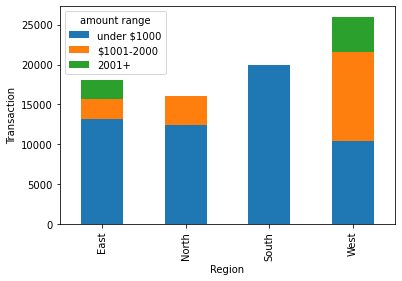

In [15]:
df=data

ax=df.groupby('region')['amount range'].value_counts().unstack(level=1).plot.bar(stacked=True)

ax.set_xlabel("Region")
ax.set_ylabel("Transaction")


* In the north region, 75% of transactions are below 1,000. Around 25% of transactions are between 1,000 to 2,000;
* In the south region, 100% of transactions are below 1,000.
* In the east region, 80% of transactions are below 1,000. Around 10% of transactions are between 1,000 to 2,000. Around 10% of transactions are above 2,000. 
* In the west region, around 40% of transactions are below 1,000. 40% of the transactions are between 1,000 to 2,000. Around 20% of transactions are above 2,000. 

Conclusion:  Customers in the south region spend the least per transaction. Customers in the west region spend the most per transaction.


Text(0, 0.5, 'Transaction')

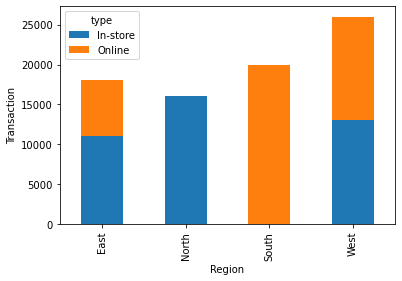

In [17]:
df=data

ax=df.groupby('region')['type'].value_counts().unstack(level=1).plot.bar(stacked=True)

ax.set_xlabel("Region")
ax.set_ylabel("Transaction")


Text(0, 0.5, 'Transaction')

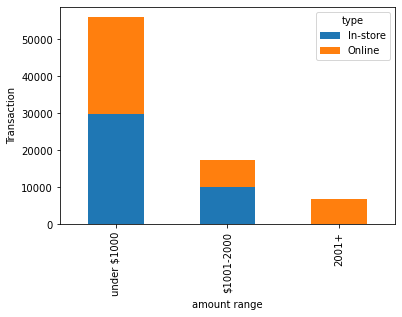

In [18]:
df=data

ax=df.groupby('amount range')['type'].value_counts().unstack(level=1).plot.bar(stacked=True)

ax.set_xlabel("amount range")
ax.set_ylabel("Transaction")

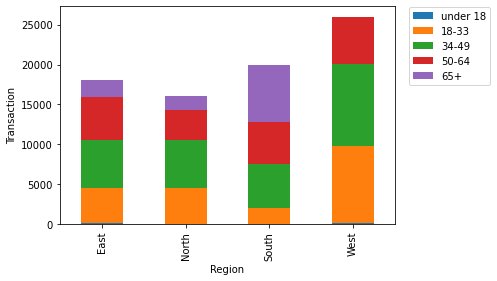

In [19]:
df=data

ax=df.groupby('region')['age group'].value_counts().unstack(level=1).plot.bar(stacked=True)

ax.set_xlabel("Region")
ax.set_ylabel("Transaction")

legend = plt.legend(bbox_to_anchor=(1.3, 1.02), bbox_transform=ax.transAxes)

* There are very few customers belong to under 18 age group in all regions
* In the East region, around 15% of the customers belong to 65+ age group while the remaining 85% is divided relatively evenly among all other age groups.
* In the North region, around 10% of the customers belong to 65+ age group while the remaining 90% is divided relatively evenly among all other age groups.
* In the South region, around 10% of the customers belong to 18-33 age group while the remaining 90% is divided relatively evenly among all other age groups.
* In the West region, around 20% of the customers belong to 50-64 age group while the remaining 80% is divided relatively evenly between the 18-33 and 34 to 49 age groups.

Conclusion:  More older customers in the south region compared to other regions. More younger customers in the west region compared to other regions.


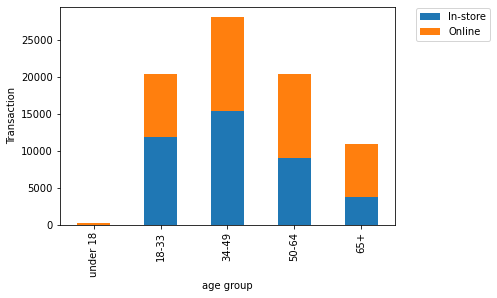

In [20]:
df=data

ax=df.groupby('age group')['type'].value_counts().unstack(level=1).plot.bar(stacked=True)

ax.set_xlabel("age group")
ax.set_ylabel("Transaction")

legend = plt.legend(bbox_to_anchor=(1.3, 1.02), bbox_transform=ax.transAxes)

* In under 18 age group, around 95% of the customers made the transaction online.
* In 18-33 age group, around 40% of the customers made the transaction online while the remaining 60% made the transaction in-store.
* In 34-49 age group, around 40% of the customers made the transaction online while the remaining 60% made the transaction in-store.
* In 50-64 age group, around 50% of the customers made the transaction online while the remaining 50% made the transaction in-store.
* In 64+ age group, around 65% of the customers made the transaction online while the remaining 35% made the transaction in-store.

Conclusion:  Older customers prefer transaction made online in our data. 


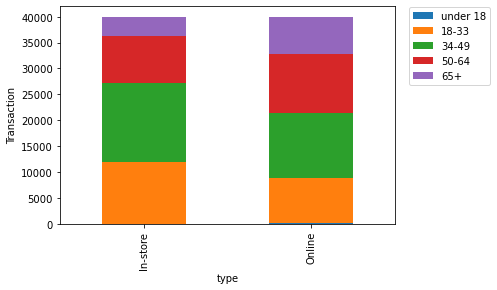

In [21]:
df=data

ax=df.groupby('type')['age group'].value_counts().unstack(level=1).plot.bar(stacked=True)

ax.set_xlabel("type")
ax.set_ylabel("Transaction")

legend = plt.legend(bbox_to_anchor=(1.3, 1.02), bbox_transform=ax.transAxes)

* In 18-33 age group, around 60% made the transaction in-store.
* But as the age increases, the in-store purchases decreased.
* In above 64 age group, only around 35% made the transaction in-store.


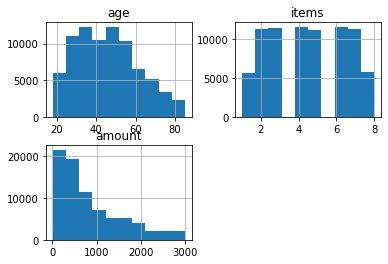

In [22]:
data.hist()
plt.show()

#### Scatter

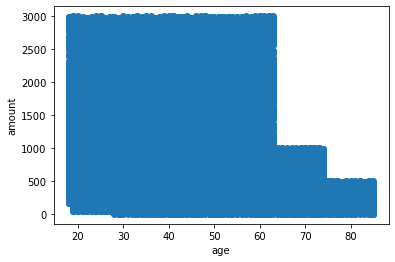

In [23]:
# Scatter plot example
data_sample = data
x = data_sample['age']
y = data_sample['amount']
plt.scatter(x,y, marker='o')
# assignment: add axis titles
plt.ylabel('amount')
plt.xlabel('age')
plt.show()


Index(['type', 'age', 'age group', 'items', 'amount', 'amount range',
       'region'],
      dtype='object')


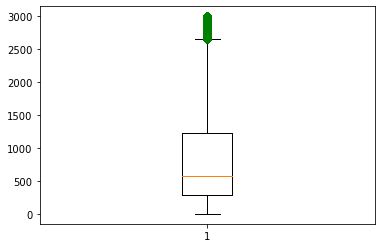

In [24]:
# Box plot example
# eval col names/features
header = data.dtypes.index
print(header)
# plot
A = data['amount']
plt.boxplot(A,0,'gD')
plt.show()


### Correlation

In [25]:
data = pd.read_csv('Demographic_Data.csv')
data.rename(columns={"in-store":"type"}, inplace=True)
data.head()

corr_mat = data.corr()
print(corr_mat)

            type       age     items    amount    region
type    1.000000 -0.178256 -0.003954 -0.085474 -0.133114
age    -0.178256  1.000000  0.000679 -0.282089 -0.235446
items  -0.003954  0.000679  1.000000  0.000367 -0.001925
amount -0.085474 -0.282089  0.000367  1.000000  0.403504
region -0.133114 -0.235446 -0.001925  0.403504  1.000000


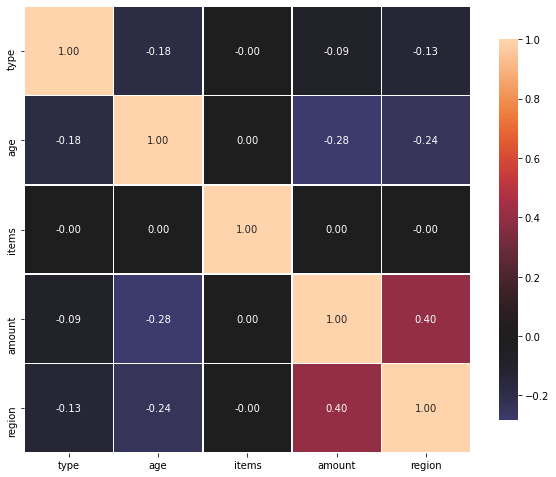

In [26]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_mat, vmax=1.0, center=0, fmt='.2f',
square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show();

* Both correlation heatmap and histogram shows a slightly negative correlation between age of a customer and if the transaction was made online or in the store.

* In the correlation matrix, it indicates -0.18 between age of a customer and place of transaction. -0.18 here means as age increases, the in-store purchase decreased.

### Covariance

In [27]:
cov_mat = data.cov()
print(cov_mat)

             type          age     items         amount      region
type     0.250003    -1.400718 -0.004075     -30.825404   -0.074988
age     -1.400718   246.982562  0.021980   -3197.566591   -4.168901
items   -0.004075     0.021980  4.248703       0.545629   -0.004471
amount -30.825404 -3197.566591  0.545629  520235.802331  327.903000
region  -0.074988    -4.168901 -0.004471     327.903000    1.269391


# Train/Test Sets
* The modeling (predicitive analytics) process begins with splitting data in to train and test sets. 


### Set random seed

In [28]:
data = pd.read_csv('Demographic_Data.csv')
data.rename(columns={"in-store":"type"}, inplace=True)

data.head()

,type,age,items,amount,region
0,0,37,4,281.03,2
1,0,35,2,219.51,2
2,1,45,3,1525.70,4
3,1,46,3,715.25,3
4,1,33,4,1937.50,1


In [29]:
category1=pd.cut(data["amount"], bins=[0,1000,2000,4000], labels=["under $1000","$1001-$2000","$2001+"])
data.insert(4,"amount range", category1)

category2=pd.cut(data["age"],bins=[0,18,33,49,64,100],labels=["under 18","18-33","34-49","50-64","65+"])
data.insert(2,"age group", category2)

data=data.drop_duplicates()
data.head(4)

,type,age,age group,items,amount,amount range,region
0,0,37,34-49,4,281.03,under $1000,2
1,0,35,34-49,2,219.51,under $1000,2
2,1,45,34-49,3,1525.70,$1001-$2000,4
3,1,46,34-49,3,715.25,under $1000,3


In [30]:
data["agebin"] = data["age group"]
data["agebin"].replace({"under 18":1, "18-33":2, "34-49":3, "50-64":4, "65+":5}, inplace = True)

data["amtbin"] = data["amount range"]
data["amtbin"].replace({"under $1000":1, "$1001-$2000":2, "$2001+":3}, inplace = True)

data.head(5)

,type,age,age group,items,amount,amount range,region,agebin,amtbin
0,0,37,34-49,4,281.03,under $1000,2,3,1
1,0,35,34-49,2,219.51,under $1000,2,3,1
2,1,45,34-49,3,1525.70,$1001-$2000,4,3,2
3,1,46,34-49,3,715.25,under $1000,3,3,1
4,1,33,18-33,4,1937.50,$1001-$2000,1,2,2


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79979 entries, 0 to 79999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   type          79979 non-null  int64   
 1   age           79979 non-null  int64   
 2   age group     79979 non-null  category
 3   items         79979 non-null  int64   
 4   amount        79979 non-null  float64 
 5   amount range  79979 non-null  category
 6   region        79979 non-null  int64   
 7   agebin        79979 non-null  int64   
 8   amtbin        79979 non-null  int64   
dtypes: category(2), float64(1), int64(6)
memory usage: 5.0 MB


In [32]:
seed = 123

### Split datasets into X (IVs) and Y (DV)
* For each ds, split into X, Y


In [33]:
# pring column names for quick reference
data.columns

Index(['type', 'age', 'age group', 'items', 'amount', 'amount range', 'region',
       'agebin', 'amtbin'],
      dtype='object')

In [34]:
## set region as dv
# select IVs/features
x_Q3 = data[['type','age','items','amount']]
x_Q3ageamt =data[['type','agebin','items','amtbin']]
y_Q3 = data['region']

In [35]:
## set in-store as dv 
x_Q4a = data[['age','items','amount','region']]
y_Q4a = data['type']

In [36]:
x_Q4b = data[['agebin','items','amtbin','region']]
y_Q4b = data['type']

### Create train and test sets

In [37]:
# region as dv; un-binned data
X_trainQ3, X_testQ3, Y_trainQ3, Y_testQ3 = train_test_split(x_Q3, y_Q3, test_size = .30, random_state = seed)

print(X_trainQ3.shape, X_testQ3.shape)
print(Y_trainQ3.shape, Y_testQ3.shape)

(55985, 4) (23994, 4)
(55985,) (23994,)


In [38]:
# region as dv; binned data
X_trainQ3ageamt, X_testQ3ageamt, Y_trainQ3, Y_testQ3 = train_test_split(x_Q3ageamt, y_Q3, test_size = .30, random_state = seed)

print(X_trainQ3ageamt.shape, X_testQ3ageamt.shape)
print(Y_trainQ3.shape, Y_testQ3.shape)

(55985, 4) (23994, 4)
(55985,) (23994,)


In [41]:
# in-store as dv; un-binned data

X_trainQ4a, X_testQ4a, Y_trainQ4a, Y_testQ4a = train_test_split(x_Q4a, y_Q4a, test_size = .30, random_state = seed)

print(X_trainQ4a.shape, X_testQ4a.shape)
print(Y_trainQ4a.shape, Y_testQ4a.shape)

(55985, 4) (23994, 4)
(55985,) (23994,)


In [42]:
# in-store as dv; age binned & amount binned

X_trainQ4b, X_testQ4b, Y_trainQ4b, Y_testQ4b = train_test_split(x_Q4b, y_Q4b, test_size = .30, random_state = seed)

print(X_trainQ4b.shape, X_testQ4b.shape)
print(Y_trainQ4b.shape, Y_testQ4b.shape)

(55985, 4) (23994, 4)
(55985,) (23994,)


# Modeling
#### Two purposes of modeling:
* 1) Evaluate patterns in data
* 2) Make predictions
  

## Evaluate patterns in data using a Decision Tree (DT)

### dv = region


In [43]:
# select DT model for classification
dt = DecisionTreeClassifier(max_depth=5)

# train/fit the mode using region as dv, and binned by age & amt
dtModel3 = dt.fit(X_trainQ3, Y_trainQ3)

# make predicitons with the trained/fit model
dtPred3 = dtModel3.predict(X_testQ3)

# performance metrics
print(accuracy_score(Y_testQ3, dtPred3))
print(classification_report(Y_testQ3, dtPred3))

0.6412853213303326
              precision    recall  f1-score   support

           1       0.40      0.52      0.45      4838
           2       0.90      1.00      0.95      5979
           3       0.53      0.23      0.32      5391
           4       0.65      0.72      0.68      7786

    accuracy                           0.64     23994
   macro avg       0.62      0.62      0.60     23994
weighted avg       0.63      0.64      0.62     23994



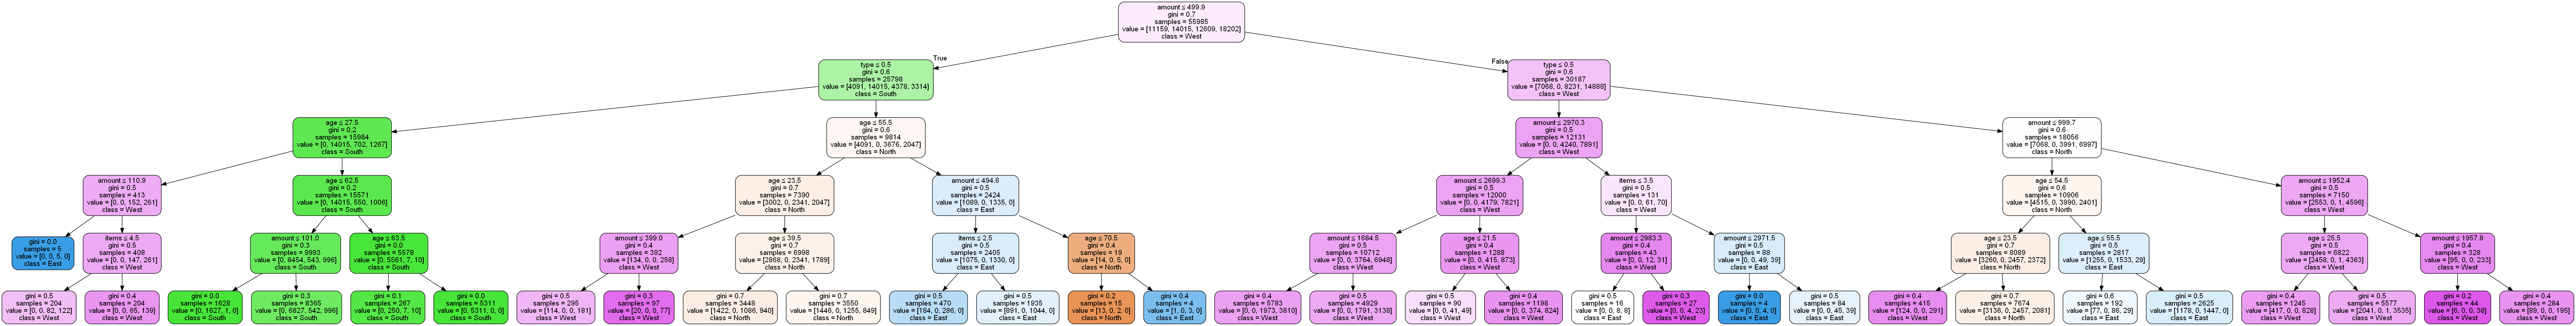

In [44]:
# visualize DT
# region_values = ['0','1','2','3'] 
region_values = ['North','South','East','West'] 

dot_data = StringIO()

export_graphviz(dtModel3,
                out_file=dot_data, 
                filled=True, 
                rounded=True,
                feature_names=X_trainQ3.columns, 
                class_names=region_values,
                label='all',
                precision=1,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

In [45]:
dtModel3.feature_importances_

array([0.47607673, 0.08113622, 0.00054782, 0.44223923])

In [46]:
importance = pd.DataFrame({"Feature_Names":X_trainQ3.columns,"Importance":dtModel3.feature_importances_})

importance.sort_values(by="Importance", ascending = False)

,Feature_Names,Importance
0,type,0.476077
3,amount,0.442239
1,age,0.081136
2,items,0.000548


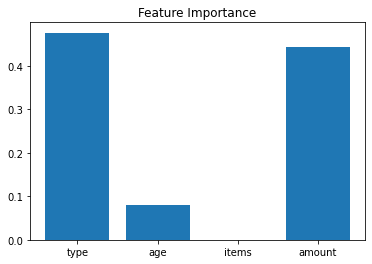

In [47]:
plt.bar(importance["Feature_Names"],importance["Importance"])
plt.title("Feature Importance")
plt.show()

In [48]:
# select DT model for classification
dt = DecisionTreeClassifier(max_depth=3)

# train/fit the mode using region as dv, and binned by age & amt
dtModel3ageamt = dt.fit(X_trainQ3ageamt, Y_trainQ3)

# make predicitons with the trained/fit model
dtPred3ageamt = dtModel3ageamt.predict(X_testQ3ageamt)

# performance metrics
print(accuracy_score(Y_testQ3, dtPred3))
print(classification_report(Y_testQ3, dtPred3))

0.6412853213303326
              precision    recall  f1-score   support

           1       0.40      0.52      0.45      4838
           2       0.90      1.00      0.95      5979
           3       0.53      0.23      0.32      5391
           4       0.65      0.72      0.68      7786

    accuracy                           0.64     23994
   macro avg       0.62      0.62      0.60     23994
weighted avg       0.63      0.64      0.62     23994



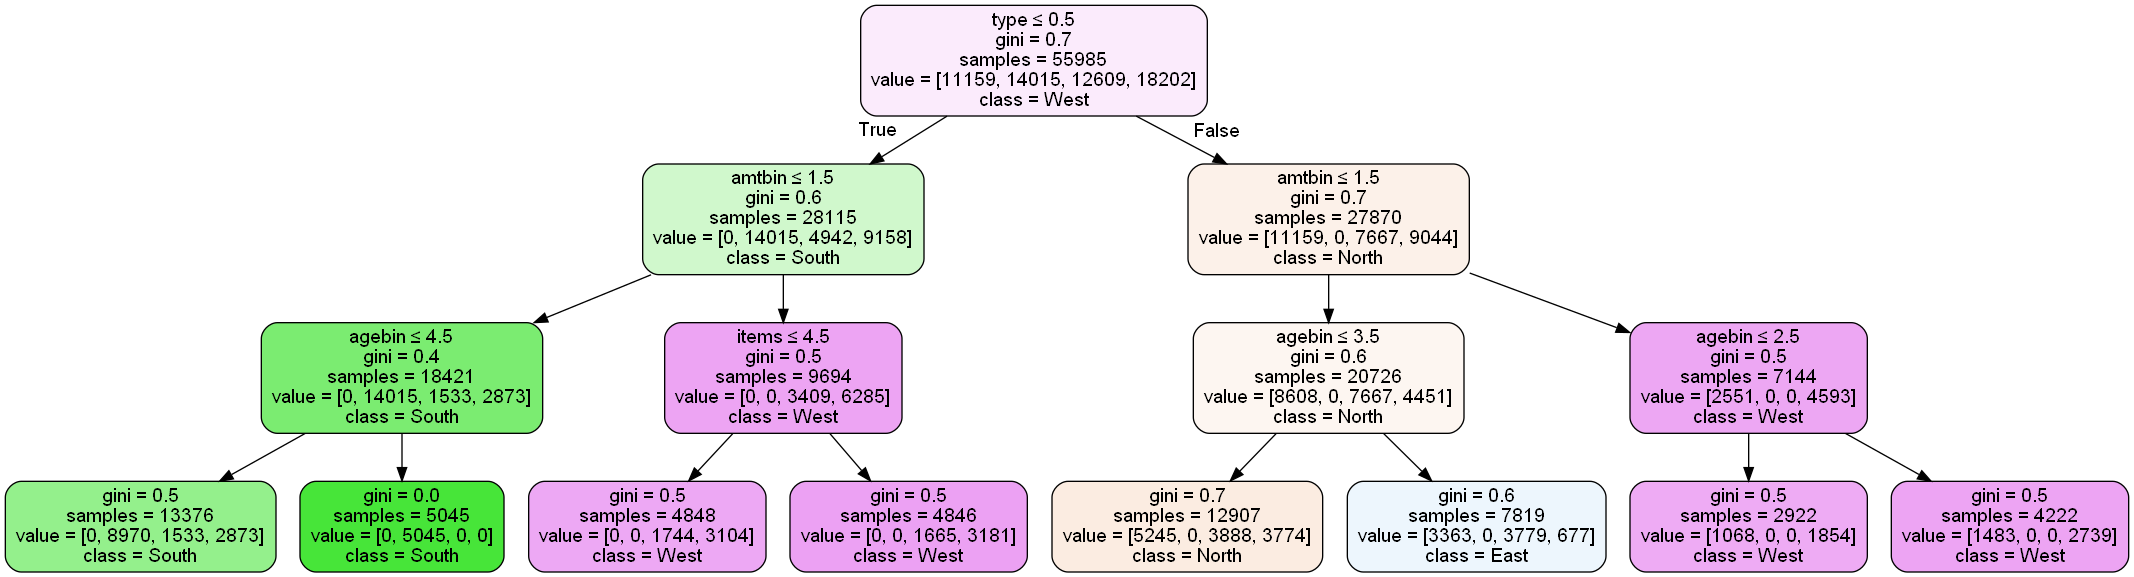

In [50]:
# visualize DT
# region_values = ['0','1','2','3'] 
region_values = ['North','South','East','West'] 

dot_data = StringIO()

export_graphviz(dtModel3ageamt,
                out_file=dot_data, 
                filled=True, 
                rounded=True,
                feature_names=X_trainQ3ageamt.columns, 
                class_names=region_values,
                label='all',
                precision=1,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

### dv = in-store


In [51]:
# select DT model for classification
dt = DecisionTreeClassifier(max_depth=8)

# train/fit the mode using type as dv
dtModel4a = dt.fit(X_trainQ4a, Y_trainQ4a)

# make predicitons with the trained/fit model
dtPred4a = dtModel4a.predict(X_testQ4a)

# performance metrics
print(accuracy_score(Y_testQ4a, dtPred4a))
print(classification_report(Y_testQ4a, dtPred4a))

0.8887221805451363
              precision    recall  f1-score   support

           0       1.00      0.78      0.87     11874
           1       0.82      1.00      0.90     12120

    accuracy                           0.89     23994
   macro avg       0.91      0.89      0.89     23994
weighted avg       0.91      0.89      0.89     23994



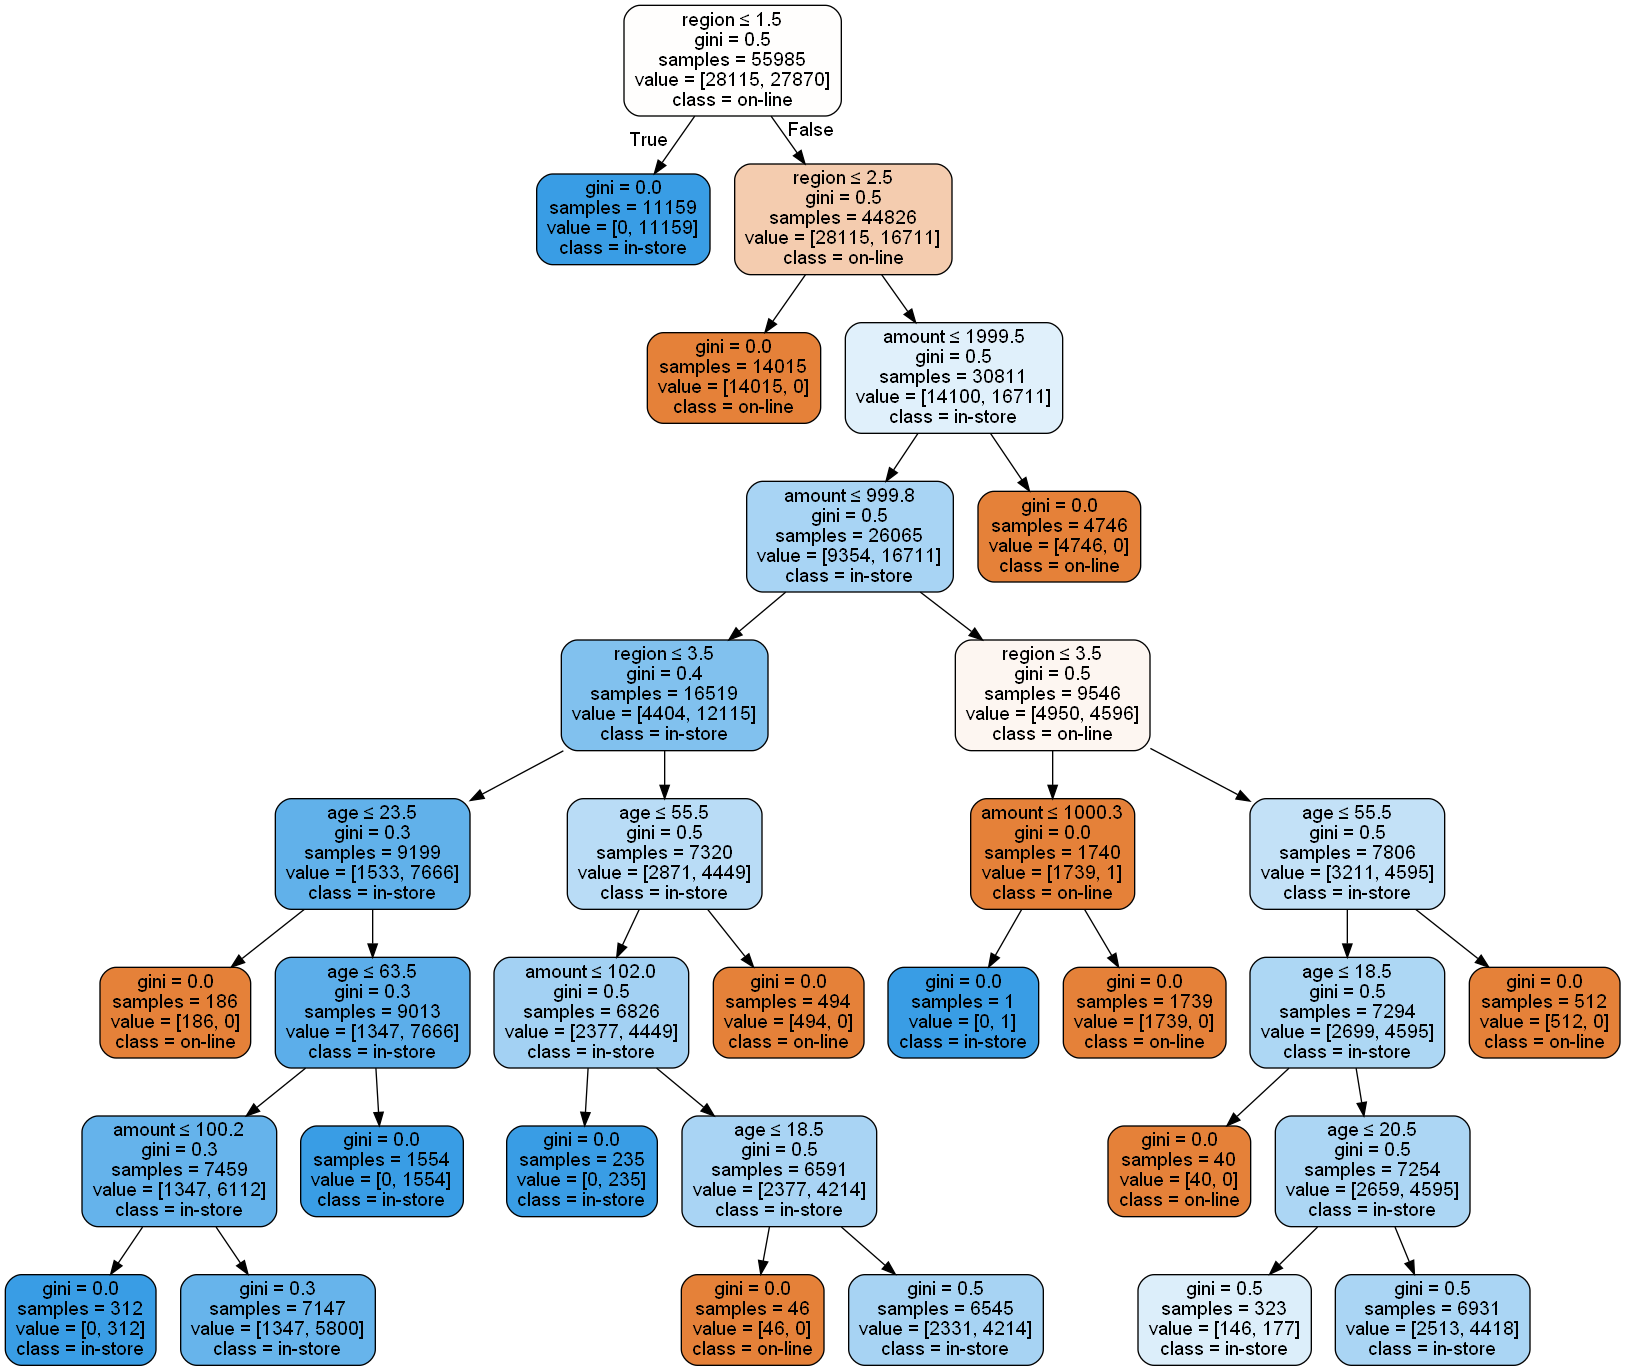

In [52]:
# visualize DT

# type_values = ['0','1'] 
type_values = ['on-line','in-store'] 

dot_data = StringIO()

export_graphviz(dtModel4a,
                out_file=dot_data, 
                filled=True, 
                rounded=True,
                feature_names=X_trainQ4a.columns, 
                class_names=type_values,
                label='all',
                precision=1,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

In [53]:
dtModel4a.feature_importances_

array([0.06138814, 0.        , 0.21352107, 0.72509079])

In [54]:
importance4a = pd.DataFrame({"Feature_Names":X_trainQ4a.columns, "importance":dtModel4a.feature_importances_})
importance4a.sort_values(by="importance", ascending = False)

,Feature_Names,importance
3,region,0.725091
2,amount,0.213521
0,age,0.061388
1,items,0.000000


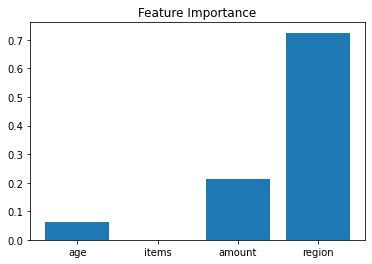

In [55]:
plt.bar(importance4a["Feature_Names"],importance4a["importance"])
plt.title("Feature Importance")
plt.show()

* There are 3 factors that predict if a customer will buy online or in store. They are region, amount and age. Region is the most correlated factor to the place of transaction. Amount is the second highly correlated factor. Age is the least correlated factor. Item is not indicated in the factors for predict the place of transaction.

In [57]:
# select DT model for classification
dt = DecisionTreeClassifier(max_depth=8)

# train/fit the mode using type as dv, age binned & amount binned
dtModel4b = dt.fit(X_trainQ4b, Y_trainQ4b)

# make predicitons with the trained/fit model
dtPred4b = dtModel4b.predict(X_testQ4b)

# performance metrics
print(accuracy_score(Y_testQ4b, dtPred4b))
print(classification_report(Y_testQ4b, dtPred4b))


0.8752604817871135
              precision    recall  f1-score   support

           0       0.94      0.80      0.86     11874
           1       0.83      0.95      0.89     12120

    accuracy                           0.88     23994
   macro avg       0.88      0.87      0.87     23994
weighted avg       0.88      0.88      0.87     23994



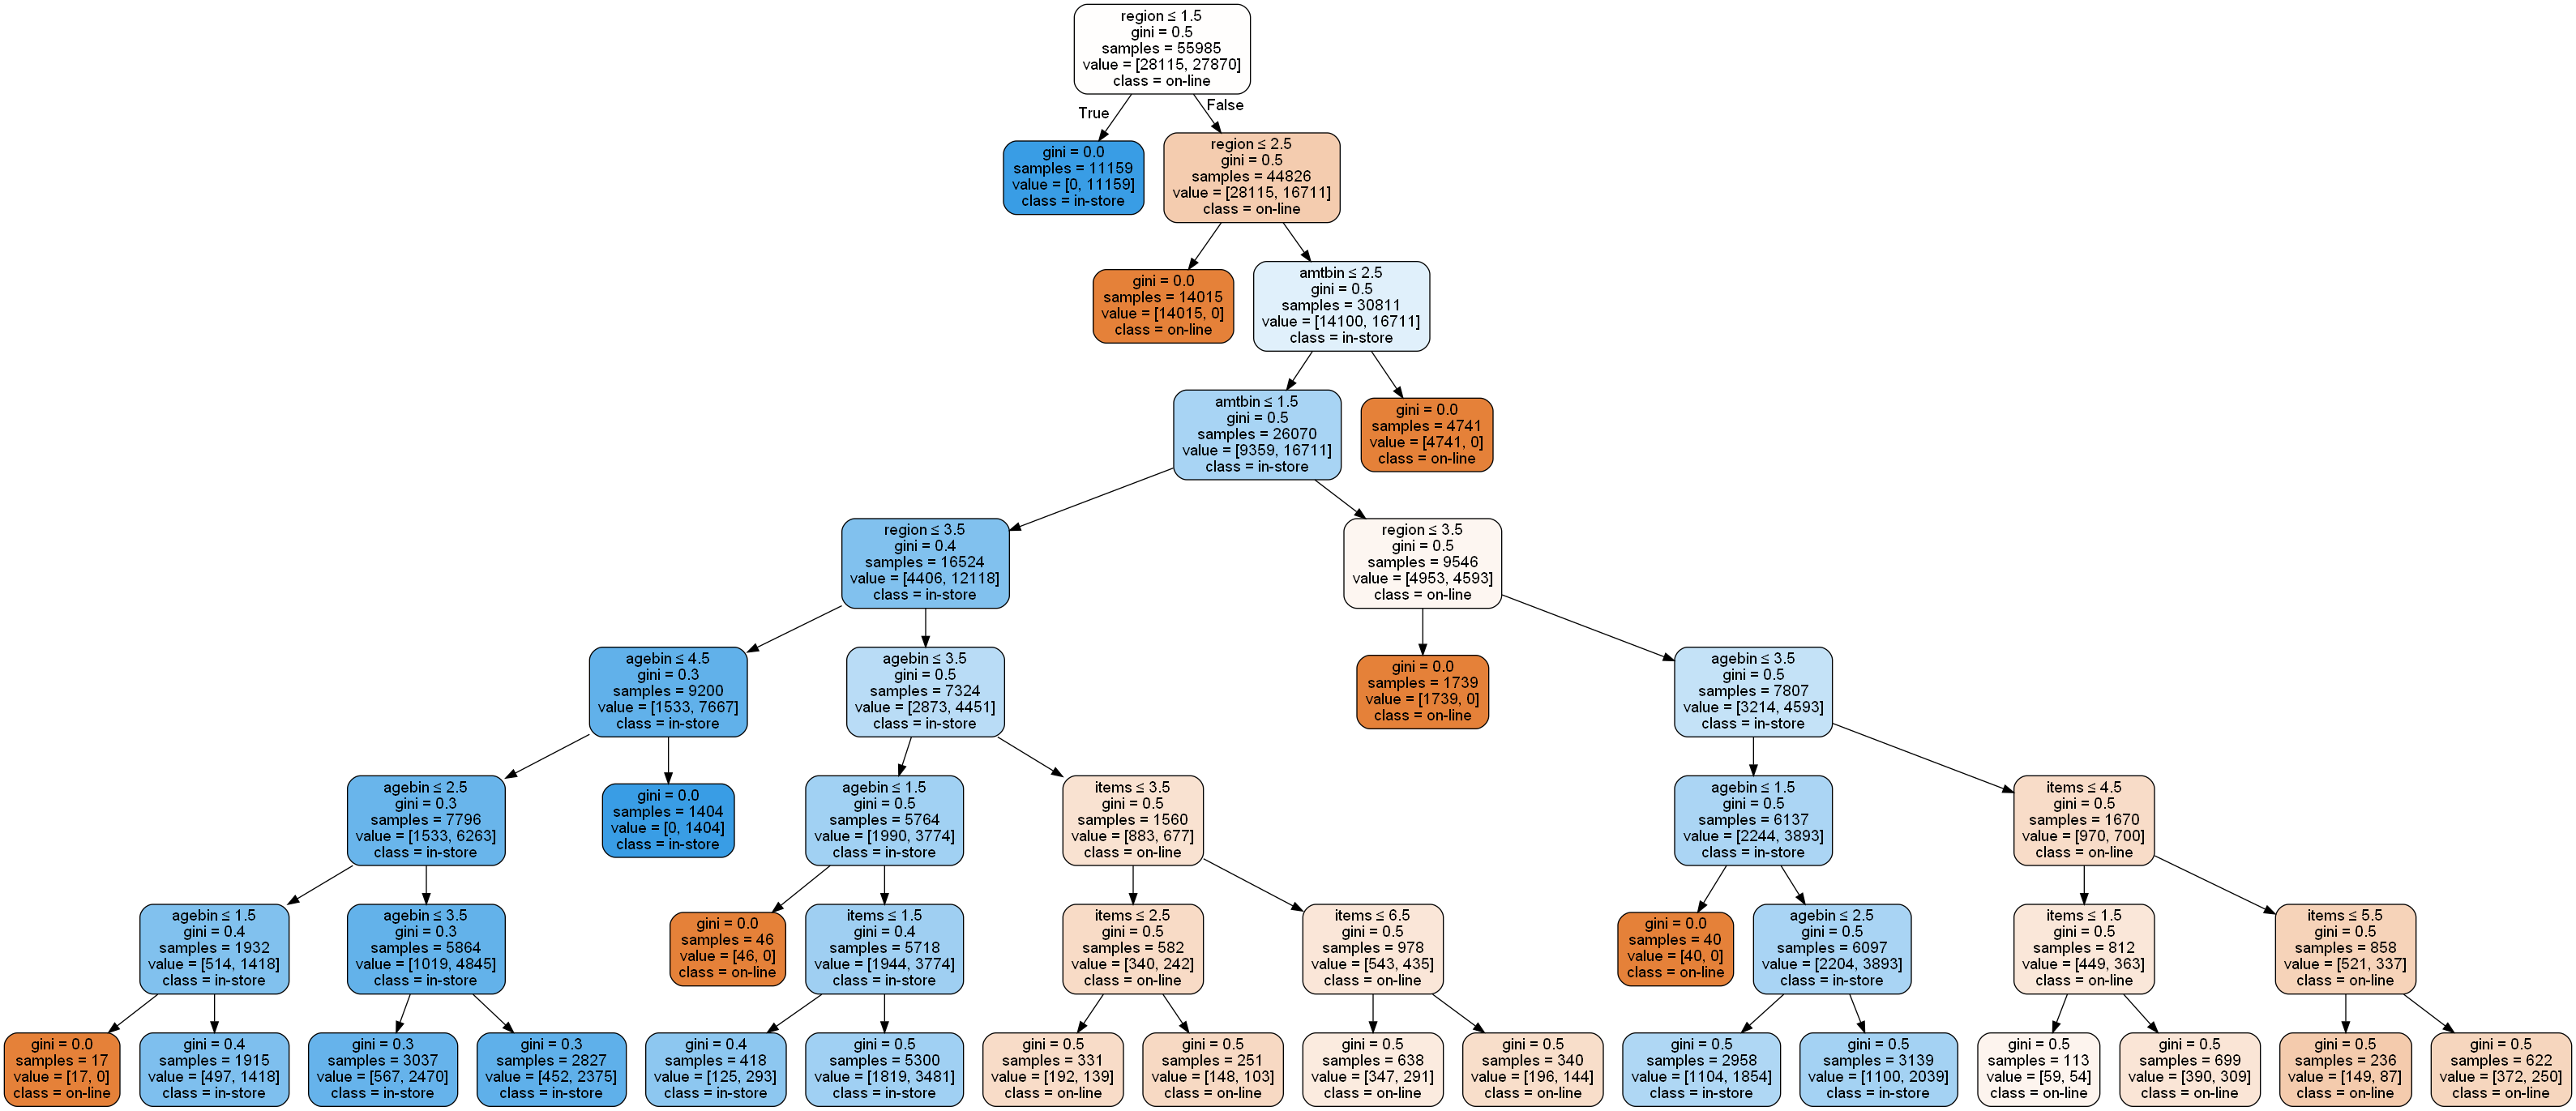

In [58]:
# visualize DT

# type_values = ['0','1'] 
type_values = ['on-line','in-store'] 

dot_data = StringIO()

export_graphviz(dtModel4b,
                out_file=dot_data, 
                filled=True, 
                rounded=True,
                feature_names=X_trainQ4b.columns, 
                class_names=type_values,
                label='all',
                precision=1,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

1. For the north region, the customers more likely make the purchase in-store. For the south region, the customers more likely make the purchase online. Neither amount nor age is indicated as a factor in the predication.
2. For the east region, the predictions are given based on both amount factor and age factor. For example:
  * If Amount Under 1,000, if the age of the customer is under 23 years old, the customer is more likely purchasing online. If the age of the customer is older than 63 years old, the customer is more likely purchasing in-store.
  * If Amount is between 1,000-2,000 and above 2,000, customer likely made purchase online. The prediction is given only based on amount factor. Because there is not a strong enough correlation to the place of transaction to make a prediction based on age.
3. For the west region, the predictions are given based on both amount factor and age factor too.

Conclusion: It interested to see from the data, All of customers from the north region made their purchases in-store while all of customers from south made their purchase online. All purchase amount above 2,000 are made online too.
